In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
print(Base.classes.keys())

['station', 'measurement']


C:\Users\Mrod9\AppData\Local\Temp\ipykernel_21100\4074313059.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

Twelve months ago: 2016-08-23
('2016-08-24', 0.08)
('2016-08-24', 2.15)
('2016-08-24', 2.28)
('2016-08-24', None)
('2016-08-24', 1.22)


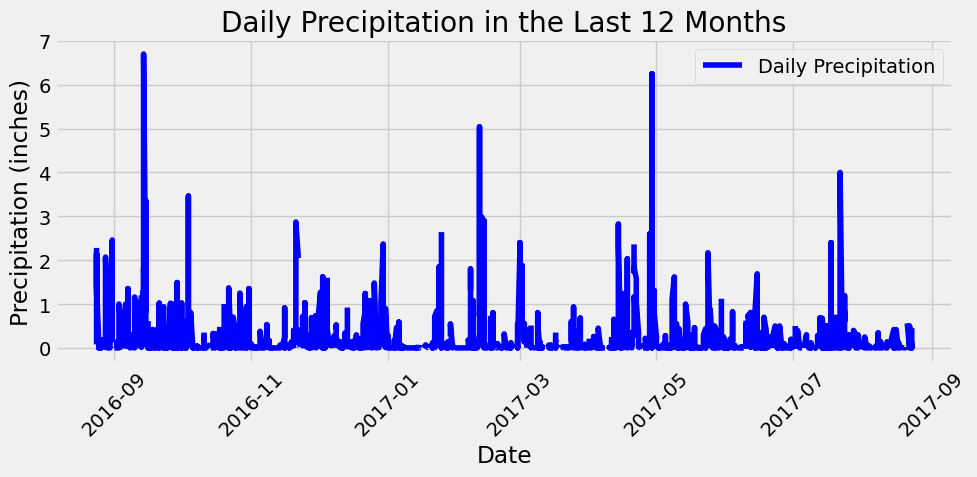

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
recent_date_obj = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
twelve_months_ago = recent_date_obj - dt.timedelta(days=365)
twelve_months_ago_str = twelve_months_ago.strftime("%Y-%m-%d")
print(f"Twelve months ago: {twelve_months_ago_str}")

# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
one_year_ago = recent_date_obj - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago) \
    .order_by(Measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
for record in precipitation_data[:5]:
    print(record)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
df_precipitation['Date'] = pd.to_datetime(df_precipitation['Date'])  

# Convertir a formato de fecha
df_precipitation = df_precipitation.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_precipitation['Date'], df_precipitation['Precipitation'], label="Daily Precipitation", color="blue")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Daily Precipitation in the Last 12 Months")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = df_precipitation['Precipitation'].describe()

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(
    Measurement.station, 
    func.count(Measurement.station).label('measurement_count')
).group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station: {station}, Number of Measurements: {count}")

Station: USC00519281, Number of Measurements: 2772
Station: USC00519397, Number of Measurements: 2724
Station: USC00513117, Number of Measurements: 2709
Station: USC00519523, Number of Measurements: 2669
Station: USC00516128, Number of Measurements: 2612
Station: USC00514830, Number of Measurements: 2202
Station: USC00511918, Number of Measurements: 1979
Station: USC00517948, Number of Measurements: 1372
Station: USC00518838, Number of Measurements: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station) \
    .all()
for stat in temperature_stats:
    print(f"Station: {most_active_station}")
    print(f"Lowest Temperature: {stat.min_temp}")
    print(f"Highest Temperature: {stat.max_temp}")
    print(f"Average Temperature: {stat.avg_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


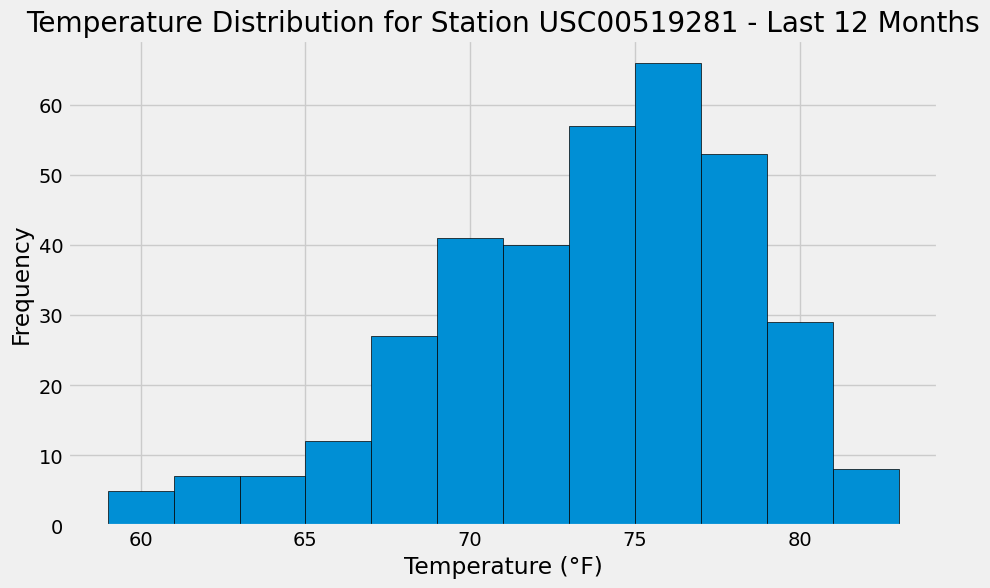

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_ago.strftime("%Y-%m-%d")
).all()
temperatures = [temp[0] for temp in temperature_data]
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f"Temperature Distribution for Station {most_active_station} - Last 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()


# Close Session

In [20]:
# Close Session
session.close()